In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
    
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
# mpl.rcParams['figure.figsize'] = (6,6)
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams["image.origin"] = 'lower'

In [2]:
config = {
    "base_dir":        "/eos/user/d/dvalsecc/www/VBSPlots/DNN_archive/FullRun2_v7",
    "plot_config":     "FullRun2_v7",
    "cut":             "res_sig",
    "model_version":   "cugini_scan/v1",
    "model_tag":       "1l_64",
    "samples_version": "v5",
    "cols": [
        "mjj_vbs",
        "Zlep",
        "vbs_1_pt",
#         "deltaeta_vbs",
#         "nJets30",
#         "vjet_1_pt",
#         
        

        #         "Lepton_eta",
#         "nJets30",
#         #"PuppiMET_pt",
#         ###"vbs_0_pt",
#         "vbs_1_pt",
#         "vjet_0_pt",
#         "vjet_1_pt",
#         "mjj_vbs",
#         "mjj_vjet",
#         "deltaeta_vbs",
#         "deltaphi_vbs",
#         "deltaeta_vjet",
#         "deltaphi_vjet",
#         #"deltaR_lep_vbs",
#         #"deltaphi_lep_nu",
#         #"deltaR_vbs",
#         #"deltaR_vjet",
#         ###"Zvjets_0",
#         #"Zvjets_1",
#         "Zlep",
#         ####"Asym_vbs",
#         #"Mtw_lep",
#         #"w_had_pt",
#         #"R_mw",
#         #"A_ww",
#         "Centr_vbs",
#         "Centr_ww",
#         "vbs_0_qglmorphed_res",
#         #"vbs_1_qgl_res",
#         "vjet_0_qglmorphed_res",
#         "vjet_1_qglmorphed_res",
#         #"four_tag_jets_HT",
#         #"four_tag_jets_pt",
#         #"vbs_jets_HT", 
#         #"v_jets_HT",
#         #"vbs_jets_pt"
#         #"cosdeltatheta_Vhad",
#         "cosdeltatheta_vjet_0"        
        ],    
    "test_size": 0.15,
    "val_size":  0.0,
    "optimizer": "adam",
    "batch_size": 32,
    "decay_weights":  'inverse', #or cyclic
    "decay_weights_pars" : [0.00001,3,0.3], #[0.00005, 0.001, 15000] 
    "patience": [15,0.0001]
}

import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

In [3]:
len(config["cols"])

3

In [4]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [417]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [58]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

N = 100000

X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight"]).values
Wnn_bkg = (bkg["weight"]).values

X = np.vstack([X_sig[:N], X_bkg[:N]])
Y = np.hstack([Y_sig[:N], Y_bkg[:N]])
W = np.hstack([W_sig[:N], W_bkg[:N]])
Wnn = np.hstack([Wnn_sig[:N], Wnn_bkg[:N]])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

##  Balancing


In [61]:
X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = \
            train_test_split(X_scaled, Y,  W, Wnn, test_size=0.5, random_state=41, stratify=Y)


#X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=config["val_size"]) ## test != val

In [7]:
print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_test.shape)
#print("Testing    dataset: ", X_test.shape)
#print("Validation dataset: ", X_val.shape)

Training   dataset:  (100000, 3)
Test + Val dataset:  (100000, 3)


Create generators to balance signal and background

## Keras model

In [8]:
%load_ext autoreload
%autoreload 2

In [18]:
import tensorflow as tf

#from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout , LeakyReLU

def get_models(spec, inputdim):
    model = Sequential()
    for i,n in enumerate(spec):
        if i ==0: 
            model.add(Dense(n, input_dim=inputdim, activation="relu"))
        else:
            model.add(Dense(n,  activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model


In [19]:
def run(nlayers, nnodes, N, output, use_weight=False ):
    feat = [nnodes] * nlayers
    # import local module that programmatically returns keras models
    import tensorflow as tf
    import dnn_models_cugini

    X_sig = signal[config["cols"]].values
    X_bkg = bkg[config["cols"]].values
    Y_sig = np.ones(len(X_sig))
    Y_bkg = np.zeros(len(X_bkg))
    W_sig = (signal["weight_norm"]).values
    W_bkg = (bkg["weight_norm"]).values
    Wnn_sig = (signal["weight"]).values
    Wnn_bkg = (bkg["weight"]).values

    X = np.vstack([X_sig[:N], X_bkg[:N]])
    Y = np.hstack([Y_sig[:N], Y_bkg[:N]])
    W = np.hstack([W_sig[:N], W_bkg[:N]])
    Wnn = np.hstack([Wnn_sig[:N], Wnn_bkg[:N]])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))
    
    X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = \
            train_test_split(X_scaled, Y,  W, Wnn, test_size=0.5, random_state=41, stratify=Y)


    model = get_models(feat, X_train.shape[1])

    model.compile(optimizer=config["optimizer"],
                loss='binary_crossentropy',
                metrics=['accuracy'])

    model.summary()

    ## TRAINING without random sampling
    import time
    start_time = time.time()
    import tensorflow as tf
    from tensorflow.keras import callbacks
    from tensorflow.keras.optimizers.schedules import InverseTimeDecay

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=config['patience'][1], patience=config['patience'][0], verbose=0, mode='auto', 
                                baseline=None, restore_best_weights=True)

    _callbacks = [early_stopping]


    # if config['decay_weights'] == 'inverse':
    #     lr_scheduler = callbacks.LearningRateScheduler(InverseTimeDecay(*config["decay_weights_pars"]))
    #     _callbacks.append(lr_scheduler)

    # if config['decay_weights'] == 'cyclic':
    #     from callbacks import CyclicLR  
    #     _callbacks.append(CyclicLR(base_lr=config["decay_weights_pars"][0],
    #                                 max_lr=config["decay_weights_pars"][1],
    #                                 step_size=config["decay_weights_pars"][2],
    #                                 mode="triangular2"))


    config["epochs"] = 100
    
    if use_weights:
        history = model.fit(
                X_train, y_train,
               sample_weight = W_train,
                epochs=config["epochs"],
                validation_data  = (X_test, y_test, W_test),
                callbacks=_callbacks,
                shuffle = True,
                batch_size= config["batch_size"],
                #callbacks = [], 
    #             class_weight= {0:1.8,1:1}
                verbose = True
            )
    else:
        history = model.fit(
                X_train, y_train,
                epochs=config["epochs"],
                validation_data  = (X_test, y_test),
                callbacks=_callbacks,
                shuffle = True,
                batch_size= config["batch_size"],
                #callbacks = [], 
    #             class_weight= {0:1.8,1:1}
                verbose = True
            )

    config["train_time"] = time.time() - start_time

    fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")

    # Evalutation
    print(">>> Computing AUC...")

    from sklearn.metrics import roc_auc_score, roc_curve, auc

    pred_test  = model.predict(X_test,  batch_size=2048)
    pred_train = model.predict(X_train, batch_size=2048)
    #auc_w_test  = roc_auc_score(y_test, pred_test,  sample_weight=W_test)
    #auc_w_train = roc_auc_score(y_train,pred_train, sample_weight=W_train)
    fpW_test,  tpW_test,  thW_test  = roc_curve(y_test,  pred_test)
    fpW_train, tpW_train, thW_train = roc_curve(y_train, pred_train)
    auc_w_test = auc(fpW_test,tpW_test)
    auc_w_train = auc(fpW_train,tpW_train)

    #print("AUC score: " + str(auc))

    fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

    # ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
    ax1.plot(fpW_test,  tpW_test,  label=f"ROC test  (AUC={auc_w_test:.3f})", color="red")
    ax1.plot(fpW_train, tpW_train, label=f"ROC train (AUC={auc_w_train:.3f})", color="blue")

    ax1.set_xlabel("Bkg contamination", fontsize=18)
    ax1.set_ylabel("Signal efficiency", fontsize=18)

    #ax1.plot([0,1],[1,1],"b--")
    ax1.tick_params("y",labelsize="large")

    ax1.grid()

    ax1.legend(loc=(0.4, 0.5), fontsize="large")

    fig.tight_layout()

    name_model = "{}l_{}_{}var".format(nlayers, nnodes,X_train.shape[1] )
    layers = nlayers
    nodes = nnodes
    nvars = X_train.shape[1]
    ntrain = N
    auc_val = auc_w_test
    auc_train = auc_w_train

    with open(output,"a") as o:
        o.write("{};{};{};{};{};{};{}\n".format(name_model, layers, nodes, nvars, ntrain, auc_val, auc_train))


1 16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
313/313 [==============================] - 1s 3ms/step - loss: 0.2951 - accuracy: 0.4896 - val_loss: 1.2646 - val_accuracy: 0.5000
Epoch 2/100
313/313 [==============================] - 1s 2ms/step - loss: 0.1586 - accuracy: 0.5000 - val_loss: 1.4676 - val_accuracy: 0.5000
Epoch 3/100
313/313 [==============================] - 1s 2ms/step - loss: 0.1436 - accuracy: 0.5000 - val_loss: 1.4712 - val_accuracy: 0.5000
Epoch 4/100
313/313 [==============================] - 1s 2ms/step - loss: 0.1404 - accu

KeyboardInterrupt: 

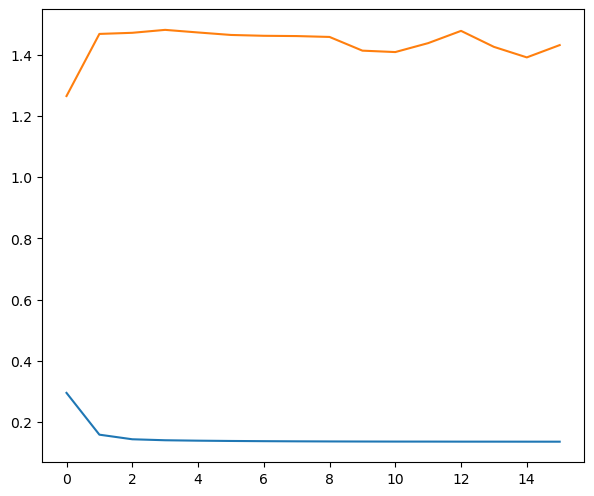

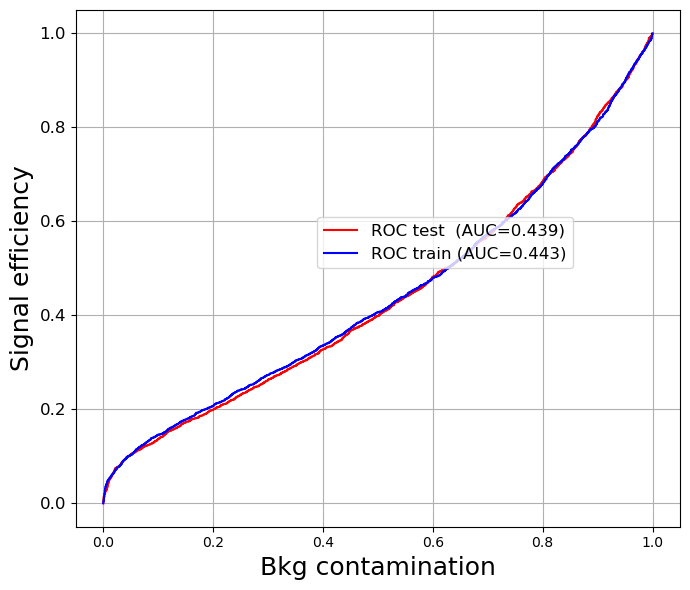

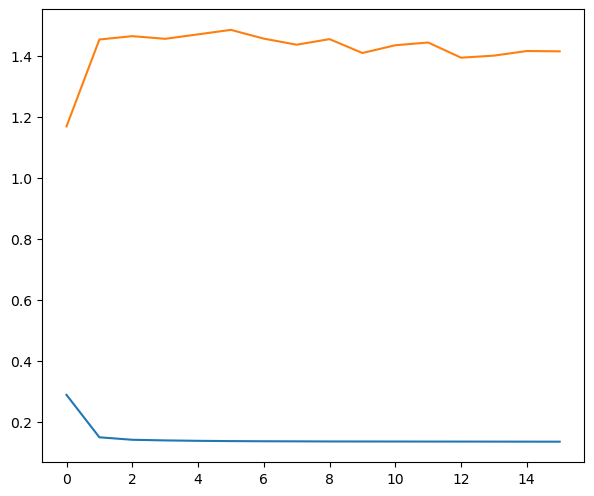

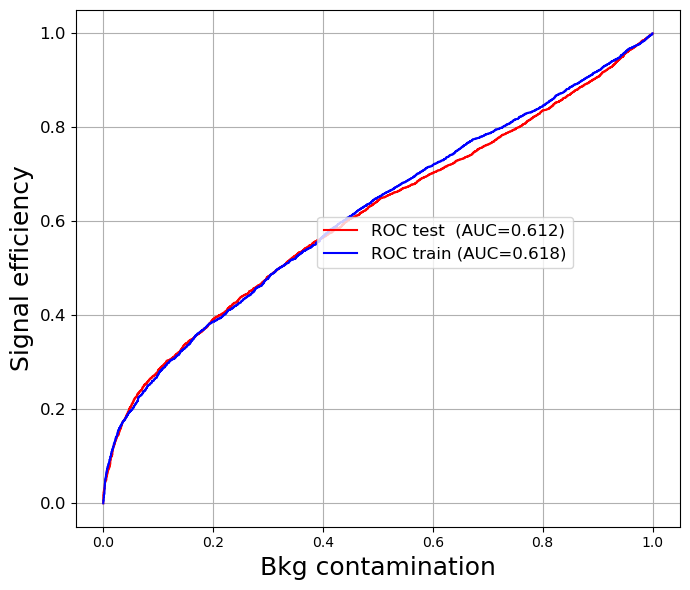

In [12]:
use_weights = True
N = 10000

for nlayer in [1,2,3,4]:
    for nnodes in [16,32,64,128]:
        print(nlayer,nnodes)
        run(nlayer,nnodes, N, "results_Aurora.csv", use_weights)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.3130e+03, 2.0050e+03, 4.0680e+03, 6.1350e+03, 1.0021e+04,
        1.0657e+04, 7.1710e+03, 3.6960e+03, 1.5940e+03, 8.1400e+02,
        4.6100e+02, 3.3000e+02, 2.1800e+02, 1.8100e+02, 1.2400e+02,
        6.8000e+01, 4.6000e+01, 3.5000e+01, 2.4000e+01, 1.1000e+01,
        1.3000e+01, 5.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-0.30696559, -0.29217099, -0.27737639, -0.26258179, -0.24778719,
        -0.23299259, -0.21819799, -0.20340338, -0.18860878, -0.17381418,
        -0.15901958, -0.14422498, -0.12943038, -0.11463578, -0.09984118,
        -0.08504658, -0.07025198, -0.05545738, -0.04066278, -0.02586818,
        -0.01107358,  0.00

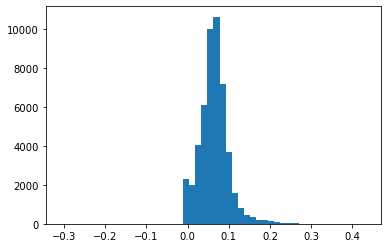

In [27]:
plt.hist(W_train[y_train==0], bins=50)

In [30]:
np.sum(W_train[y_train==0])

3218.47901011484

In [29]:
np.sum(W_train[y_train==1])

51654.26377079837

(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 5.000e+00, 7.000e+00,
        8.000e+00, 1.000e+01, 1.600e+01, 1.900e+01, 1.700e+01, 2.049e+03,
        4.329e+03, 5.887e+03, 5.298e+03, 6.233e+03, 5.849e+03, 4.056e+03,
        2.439e+03, 1.611e+03, 1.293e+03, 1.321e+03, 1.421e+03, 1.453e+03,
        1.388e+03, 1.255e+03, 1.046e+03, 8.360e+02, 6.270e+02, 4.690e+02,
        3.410e+02, 2.550e+02, 1.560e+02, 8.700e+01, 7.600e+01, 3.700e+01,
        3.000e+01, 1.000e+01, 1.200e+01, 1.500e+01, 1.200e+01, 7.000e+00,
        2.000e+00, 5.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([-1.97435175, -1.80335424, -1.63235673, -1.46135922, -1.29036171,
        -1.1193642 , -0.94836669, -0.77736918, -0.60637167, -0.43537416,
        -0.26437665, -0.09337914,  0.07761837,  0.24861588,  0.41961339,
         0.5906109 ,  0.76160842,  0.93260593,  1.10360344,  1.27460095,
         1.44559846,  1.61659597,  1.78759348,  1.95859099,  2.1295885 ,
         2.

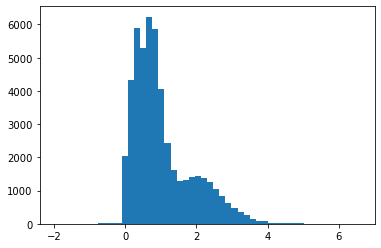

In [28]:
plt.hist(W_train[y_train==1], bins=50)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_43 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_44 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 17        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
313/313 [==============================] - 2s 7ms/step - loss: 0.2187 - accuracy: 0.4994 - val_loss: 0.1444 - val_accuracy: 0.5000
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 0.1400 - accuracy: 0.5000 - val_loss

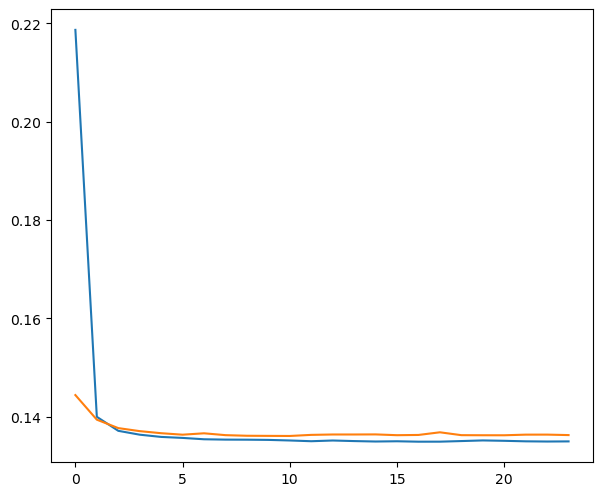

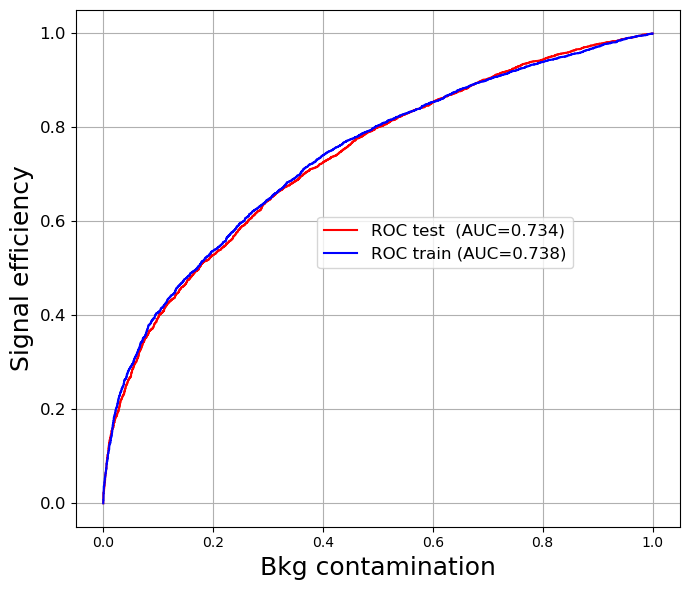

In [22]:
run(3,16, 10000, "test.csv", False)

In [468]:
df = pd.read_csv("results_cugini.csv",sep=";")

In [454]:
df

,name,layers,nodes,nvars,ntrain,auc_val,auc_train
0,1l_16_2var,1,16,2,4000,0.662368,0.683749
1,1l_32_2var,1,32,2,4000,0.663154,0.682415
2,1l_64_2var,1,64,2,4000,0.662881,0.681792
3,2l_16_2var,2,16,2,4000,0.663026,0.680929
4,2l_32_2var,2,32,2,4000,0.663378,0.682699
5,2l_64_2var,2,64,2,4000,0.663597,0.684108
6,2l_128_2var,2,128,2,4000,0.664172,0.684306
7,3l_16_2var,3,16,2,4000,0.662723,0.683766
8,3l_32_2var,3,32,2,4000,0.664170,0.684547
9,3l_64_2var,3,64,2,4000,0.663510,0.685685


In [455]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
# Overall - both left and right annotation

Text(0, 1, 'AUC')

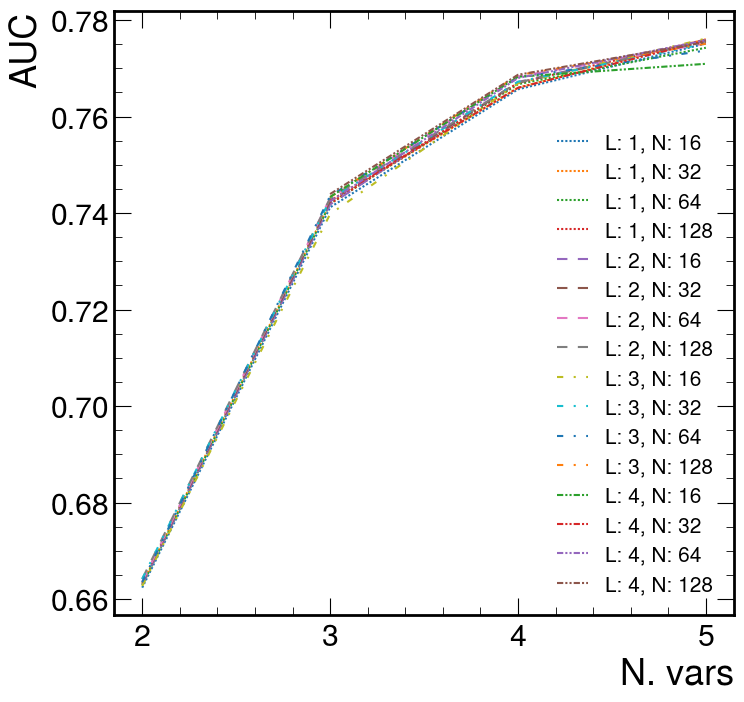

In [465]:
fig, ax1 = plt.subplots(figsize=(8,8), dpi=100)
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),

     ('dashed',                (0, (5, 5))),

     ('dashdotted',            (0, (3, 5, 1, 5))),

     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

for nlayer in [1,2,3,4]:
    for nnodes in [16,32,64,128]:
        a = df[(df.nodes==nnodes)&(df.layers==nlayer) & (df.ntrain==4000)]
        ax1.plot(a.nvars, a.auc_val, label="L: {}, N: {}".format(nlayer,nnodes), linestyle=linestyle_tuple[nlayer-1][1])
ax1.legend(fontsize="xx-small")
ax1.set_xlabel("N. vars")
ax1.set_ylabel("AUC")

Text(0, 1, 'AUC')

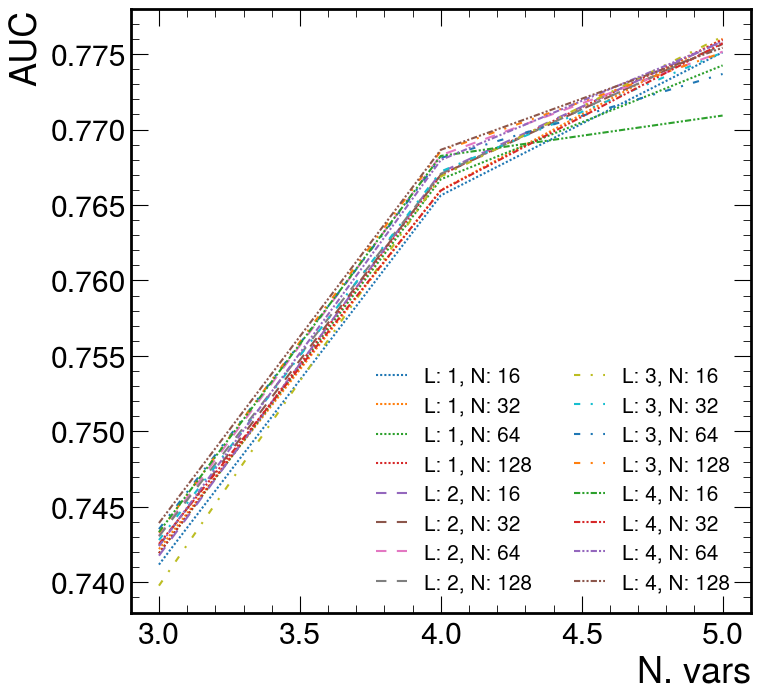

In [467]:
fig, ax1 = plt.subplots(figsize=(8,8), dpi=100)
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),

     ('dashed',                (0, (5, 5))),

     ('dashdotted',            (0, (3, 5, 1, 5))),

     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

for nlayer in [1,2,3,4]:
    for nnodes in [16,32,64,128]:
        a = df[(df.nodes==nnodes)&(df.layers==nlayer) & (df.ntrain==4000) & (df.nvars> 2)]
        ax1.plot(a.nvars, a.auc_val, label="L: {}, N: {}".format(nlayer,nnodes), linestyle=linestyle_tuple[nlayer-1][1])
ax1.legend(fontsize="xx-small",ncol=2)
ax1.set_xlabel("N. vars")
ax1.set_ylabel("AUC")

316
Model: "sequential_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_716 (Dense)            (None, 128)               512       
_________________________________________________________________
dense_717 (Dense)            (None, 1)                 129       
_________________________________________________________________
dense_718 (Dense)            (None, 128)               256       
_________________________________________________________________
dense_719 (Dense)            (None, 1)                 129       
_________________________________________________________________
dense_720 (Dense)            (None, 128)               256       
_________________________________________________________________
dense_721 (Dense)            (None, 1)                 129       
_________________________________________________________________
dense_722 (Dense)            (None, 128)        

32/32 [==============================] - 0s 8ms/step - loss: 0.6935 - accuracy: 0.4800 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.4780 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4760 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.4860 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/100
32/32 [======

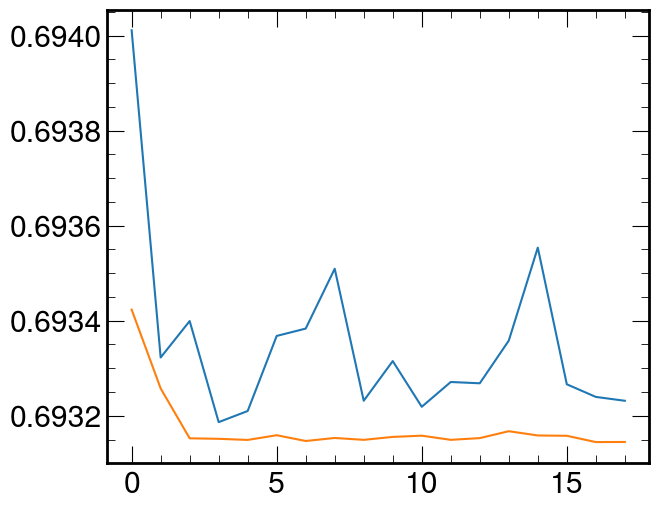

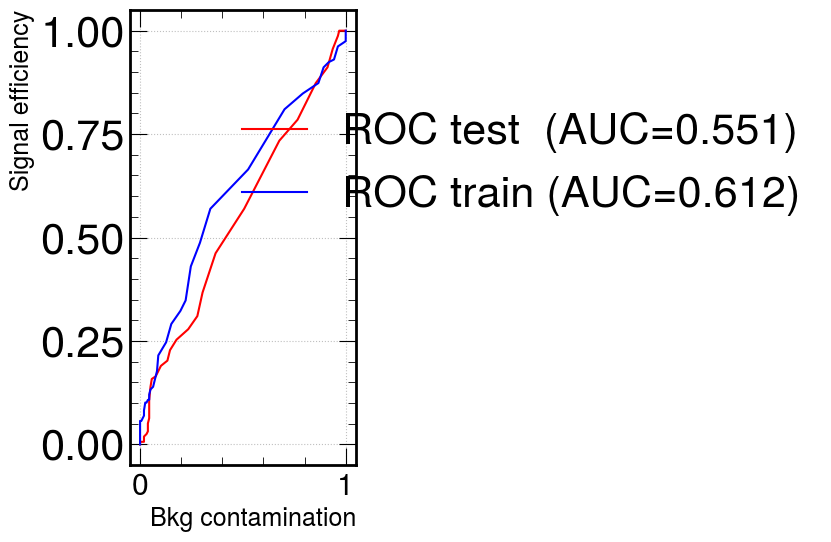

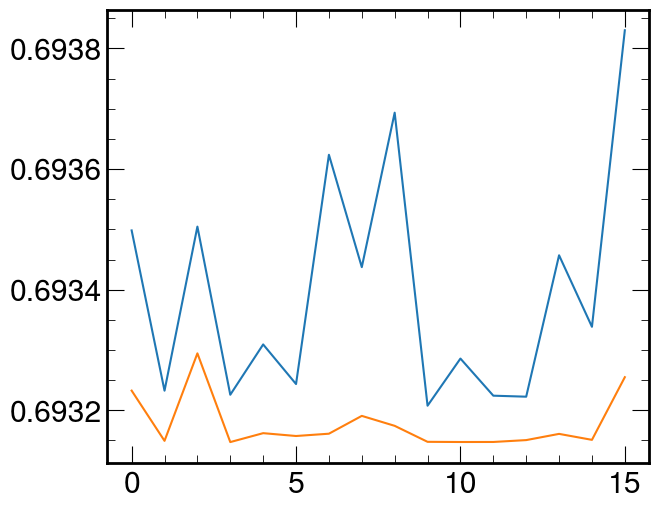

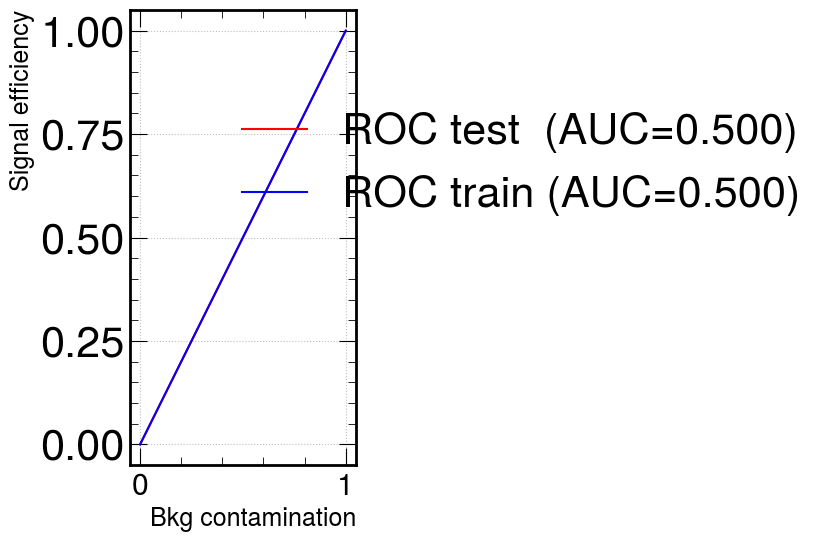

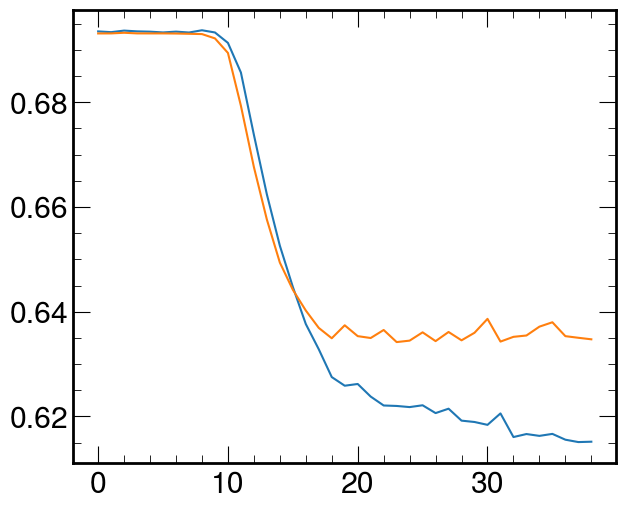

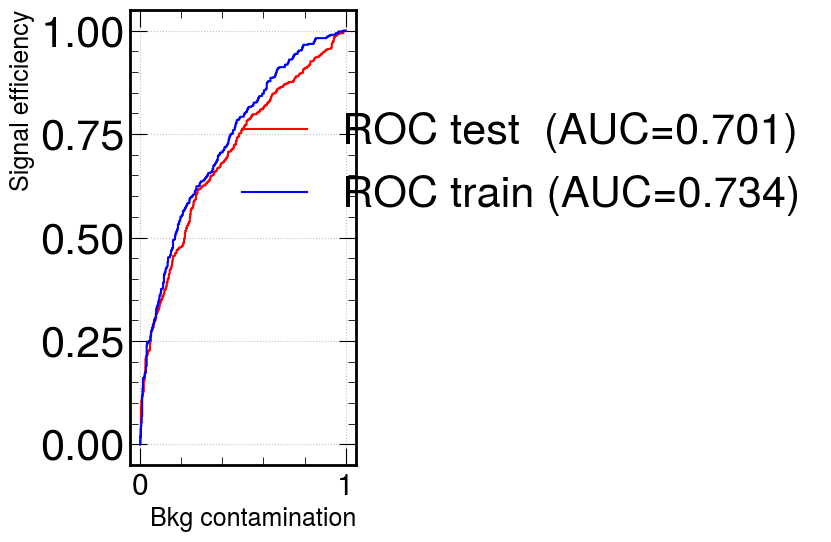

In [512]:
for N in [int(x) for x in np.logspace(2.5, 3,3)]:
    print(N)
    run(4,128, N,"results_cugini_ntrain.csv")

Text(0, 1, 'AUC')

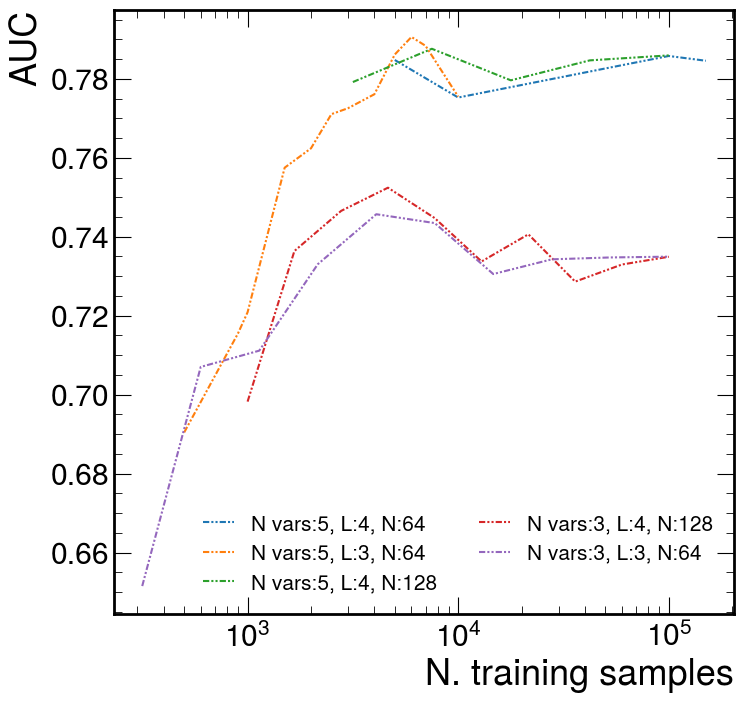

In [514]:
df = pd.read_csv("results_cugini_ntrain.csv",sep=";")

fig, ax1 = plt.subplots(figsize=(8,8), dpi=100)
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),

     ('dashed',                (0, (5, 5))),

     ('dashdotted',            (0, (3, 5, 1, 5))),

     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

for nvar in [5]:
    for arch in [[4,64],[3,64],[4,128]]:
        a = df[(df.nodes==arch[1])& (df.layers==arch[0])  & (df.nvars == nvar)]
        ax1.plot(a.ntrain, a.auc_val, label="N vars:{}, L:{}, N:{}".format(nvar, arch[0], arch[1]), linestyle=linestyle_tuple[nlayer-1][1])
for nvar in [3]:
    for arch in [[4,128],[3,64]]:
        a = df[(df.nodes==arch[1])& (df.layers==arch[0])  & (df.nvars == nvar)]
        ax1.plot(a.ntrain, a.auc_val, label="N vars:{}, L:{}, N:{}".format(nvar, arch[0], arch[1]), linestyle=linestyle_tuple[nlayer-1][1])
ax1.legend(fontsize="xx-small",ncol=2)
ax1.set_xscale("log")
ax1.set_xlabel("N. training samples")
ax1.set_ylabel("AUC")